Classification - Testing different models on one data set

In [1]:
# Import Libraries and Modules
import pandas as pd
import numpy as np
import time
from pandas_datareader import data, wb
from datetime import datetime
import matplotlib.pyplot as plt

Prepare Data

In [2]:
# Setting the Date
start = pd.to_datetime('2018-01-01')
end = pd.to_datetime('today')

In [3]:
# Pandas DataReader API (Quandl, Google, Yahoo, AlphaVantage, sooq ...)
Tickers = ['QQQ'] #'AAPL', 'TSLA', 'MSFT', 'AMZN', 'SPY'
Stock_df = data.DataReader(Tickers, 'yahoo', start, end)
Stock_df.reset_index( drop=False, inplace=True)
Stock_df['Date'] = pd.to_datetime(Stock_df['Date'])
Stock_df.reset_index( drop=True, inplace=True)
Stock_df.sort_values( by=['Date'], ascending=True, inplace=True)
#Stock_df.columns = Stock_df.columns.droplevel(-1)
Stock_df.head()

Attributes,Date,Adj Close,Close,High,Low,Open,Volume
Symbols,,QQQ,QQQ,QQQ,QQQ,QQQ,QQQ
0,2018-01-02,155.276016,158.490005,158.529999,156.169998,156.559998,32573300.0
1,2018-01-03,156.784760,160.029999,160.169998,158.610001,158.639999,29383600.0
2,2018-01-04,157.059082,160.309998,160.789993,160.080002,160.580002,24776100.0
3,2018-01-05,158.636444,161.919998,162.029999,160.770004,161.070007,26992300.0
4,2018-01-08,159.253693,162.550003,162.630005,161.860001,161.919998,23159100.0


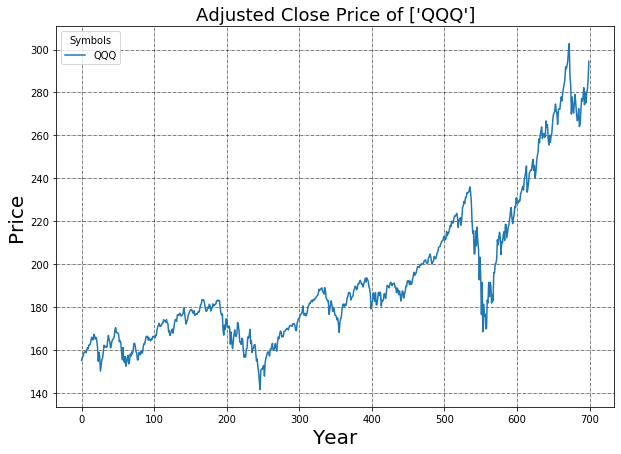

In [4]:
# Plot the adjusted close price
Stock_df['Adj Close'].plot( figsize = ( 10, 7))
# Define the label for the title of the figure
plt.title( "Adjusted Close Price of %s" % Tickers, fontsize = 18)
# Define the labels for x-axis and y-axis
plt.ylabel( 'Price', fontsize = 20)
plt.xlabel( 'Year', fontsize = 20)
# Plot the grid lines
plt.grid( which="major", color = 'k', linestyle = '-.', linewidth = 0.5)
# Show the plot
plt.show()

In [5]:
# Data Aggregations on adjusted closing price
Stock_df['Avg_5'] = Stock_df['Adj Close'].rolling( window = 5, center = False).mean()
Stock_df['Avg_30'] = Stock_df['Adj Close'].rolling( window = 30, center = False).mean()
Stock_df['Avg_365'] = Stock_df['Adj Close'].rolling( window = 365, center = False).mean()
Stock_df['Std_5'] = Stock_df['Adj Close'].rolling( window = 5, center = False).std()
Stock_df['Std_30'] = Stock_df['Adj Close'].rolling( window = 365, center = False).std()
Stock_df['Std_365'] = Stock_df['Adj Close'].rolling( window = 365, center = False).std()
Stock_df['Avg_5/365'] = Stock_df['Avg_5']/Stock_df['Avg_365']
Stock_df['Std_5/365'] = Stock_df['Std_5']/Stock_df['Std_365']

Stock_df = Stock_df.shift( periods = 1)
Stock_df.dropna( how= 'any', axis = 0, inplace = True)

Stock_df.head()

Attributes,Date,Adj Close,Close,High,Low,Open,Volume,Avg_5,Avg_30,Avg_365,Std_5,Std_30,Std_365,Avg_5/365,Std_5/365
Symbols,,QQQ,QQQ,QQQ,QQQ,QQQ,QQQ,,,,,,,,
365,2019-06-14,180.776596,182.639999,183.110001,181.940002,182.479996,22844100.0,181.123016,179.196209,169.478958,0.475626,9.441139,9.441139,1.068705,0.050378
366,2019-06-17,181.865387,183.740005,184.250000,182.839996,183.039993,20379500.0,181.239819,178.953050,169.551805,0.583675,9.433827,9.433827,1.068935,0.061870
367,2019-06-18,184.508118,186.410004,187.720001,185.429993,185.910004,48177300.0,181.835672,178.836583,169.627760,1.595755,9.442354,9.442354,1.071969,0.169000
368,2019-06-19,185.200989,187.110001,187.529999,185.570007,186.660004,31672900.0,182.779944,178.865287,169.704861,1.950256,9.454331,9.454331,1.077046,0.206282
369,2019-06-20,186.923233,188.850006,189.759995,187.160004,189.720001,40922000.0,183.854865,178.966906,169.782359,2.504368,9.479255,9.479255,1.082886,0.264195


In [6]:
# Splitting Data to Training and Test sets
df_train = Stock_df[Stock_df['Date'] < datetime(year = 2019, month = 9, day = 1)]
df_test = Stock_df[Stock_df['Date'] >= datetime(year = 2019, month = 9, day = 1)]
features = ['Avg_5', 'Avg_30', 'Avg_365', 'Std_5', 'Std_30', 'Std_365', 'Avg_5/365', 'Std_5/365']
target = ['Adj Close']
X = df_train[features]
X_test = df_test[features]
y = df_train[target]
y_test = df_test[target]

Linear Regression Model

In [8]:
# Fitting Linear Regression to the dataset and predicting a new result
from sklearn.linear_model import LinearRegression
linear = LinearRegression()
linear.fit(X, y)
print("Coef: ", linear.coef_)
print("Intercept: ", linear.intercept_)
y_pred_linear = linear.predict(X_test)

Coef:  [[-4.02150870e+01  2.37214349e-01  4.22658498e+01 -4.06325468e+01
   4.75051439e+00  4.75051438e+00  6.99373666e+03  4.04046810e+02]]
Intercept:  [-7305.91902369]


In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae_l = mean_absolute_error( y_test, y_pred_linear)
mse_l = mean_squared_error( y_test, y_pred_linear)

print("MAE: ", mae_l)
print("MSE: ", mse_l)
print("RMSE: ", np.sqrt(mse_l))
print("Score: ", linear.score(X, y))
#r2_score(y , y_pred_linear)

MAE:  131.94560689158894
MSE:  38356.344472762496
RMSE:  195.84775840627458
Score:  0.8150607882340065


Random Forest Regression Model

In [10]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 10, random_state = 0)
regressor.fit(X, y)
#print("Coef: ", regressor.coef_)
#print("Intercept: ", regressor.intercept_)
y_pred_rf = regressor.predict(X_test)

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae_rf = mean_absolute_error( y_test, y_pred_rf)
mse_rf = mean_squared_error( y_test, y_pred_rf)

print("MAE: ", mae_rf)
print("MSE: ", mse_rf)
print("RMSE: ", np.sqrt(mse_rf))
print("Score: ", regressor.score(X, y))

MAE:  36.6840817642212
MSE:  2271.000980500375
RMSE:  47.65502051725899
Score:  0.9355433916018384


XGBoost Model

In [12]:
from xgboost import XGBRegressor
xgb = XGBRegressor(silent = True)
xgb.fit(X, y)
y_pred_xgb = xgb.predict(X_test)

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae_xgb = mean_absolute_error( y_test, y_pred_xgb)
mse_xgb = mean_squared_error( y_test, y_pred_xgb)

print("MAE: ", mae_xgb)
print("MSE: ", mse_xgb)
print("RMSE: ", np.sqrt(mse_xgb))
print("Score: ", xgb.score(X, y))

MAE:  37.54488677978516
MSE:  2332.85961813398
RMSE:  48.299685486905396
Score:  0.9861275583763045


Long Short-Term Memory (LSTM) Model

Applying k-Fold Cross Validation

In [14]:
from sklearn.model_selection import cross_val_score
models = [linear, regressor, xgb]
for model in models:
    accuracies = cross_val_score(estimator = model, X = X, y = y, cv = 10)
    print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
    print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: -121.98 %
Standard Deviation: 144.45 %
Accuracy: -171.23 %
Standard Deviation: 179.21 %
Accuracy: -150.11 %
Standard Deviation: 149.65 %


Applying Grid Search to find the best model and the best parameters

In [25]:
from sklearn.model_selection import GridSearchCV
parameters = [{'C': [0.25, 0.5, 0.75, 1], 'kernel': ['linear']},
              {'C': [0.25, 0.5, 0.75, 1], 'kernel': ['rbf'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}]
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300]
}
grid_search = GridSearchCV(estimator = regressor,
                           param_grid = param_grid,               
                           cv = 10,
                           n_jobs = -1,
                           verbose = 2)
grid_search.fit(X, y)
#best_accuracy = grid_search.best_score_
#best_parameters = grid_search.best_params_
#print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
#print("Best Parameters:", best_parameters)
grid_search.best_params_
best_grid = grid_search.best_estimator_


Fitting 10 folds for each of 216 candidates, totalling 2160 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1124 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:   12.8s finished
C:\Users\JKIDER\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [ ]:
# Visualising the Training set results
# Visualising the Test set results